# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [ ]:
!conda install -c conda-forge -y librosa

In [18]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange
import torch.nn.functional as F

# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [202]:
def load_mel(file_name, start=0, stop=None, n_mels=60):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 6000, fmax = 9000)
#     spectrogram = stats.boxcox(spectrogram, lmbda=0.043, alpha=0.000001)

#     mfccs = librosa.feature.mfcc(S=spectrogram, norm='ortho', dct_type=3)
#     return mfccs
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram

def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = [file_name for file_name in os.listdir('test') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)

def load_test_2(load_repr=load_mel, interval=0.3, step=0.05):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    X_test = []
    compartment = interval / 2
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    
    rec_files = sorted([file_name for file_name in os.listdir('test') 
                        if file_name.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    recordings_ids = []
    for file_name in tqdm(rec_files):
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            for i in np.arange(t + compartment, t + 1 - compartment, step): 
                representation = load_repr(os.path.join('test', file_name), start = i - compartment, stop = i + compartment)
                X_test.append(representation)
                recordings_ids.append("{}/{}".format(recording_id, t))
    return np.array(X_test), recordings_ids


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0., compartment=0.3):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + compartment - tol) or \
           (labels[2] < second + compartment and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + compartment)


def map_seconds_to_y(labels, interval=0.05, compartment=0.3):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y_len = int((10 - compartment) / interval)
    y = [0] * y_len 
    y_restrictive = [0] * y_len 
    for s in range(y_len):
        for l in labels:
            if check_voices(s * interval, l):
                y[s] = 1
#             if check_voices(s, l, 0.00002):
#                 y_restrictive[s] = 1
#         if y[s] != y_restrictive[s]:
#             y[s] = -1
    return y


def load_train(load_repr=load_mel, interval=0.05, compartment=0.3):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    for file_name in tqdm(rec_files):
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start = i * interval , stop = i * interval + compartment)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

def prepare_training_set(labels, interval):
    starts, stops, y_binary = [], [], []
    compartment = interval / 2
    extra_compartments = []
    extra_compartments.append(compartment / 2)
    extra_compartments.append(compartment / 3)
    extra_compartments.append(compartment / 4)
                              
    # creating positive samples 
    for label in labels:
        middle = label[1] + (label[2] - label[1]) / 2 
        start = middle - compartment
        starts.append(start)
        stop = middle + compartment
        stops.append(stop)
        
        if start < 0 or stop > 10:
            y_binary.append(-1)
        else: 
            y_binary.append(1)
        
        for extra_comp in extra_compartments:
            new_start = start + extra_comp
            new_stop = stop + extra_comp
            starts.append(new_start)
            stops.append(new_stop)
            
            if new_start < 0 or new_stop > 10:
                y_binary.append(-1)
            else: 
                y_binary.append(1)
                
            new_start = start - extra_comp
            new_stop = stop - extra_comp
            starts.append(new_start)
            stops.append(new_stop)
            
            if new_start < 0 or new_stop > 10:
                y_binary.append(-1)
            else: 
                y_binary.append(1)
        
    # creating negative samples
    loop_counter = len(y_binary) 
    while loop_counter:
        middle = torch.FloatTensor(1).uniform_(compartment, 10 - compartment).numpy()
        start = middle - compartment 
        stop = middle + compartment
        check = np.zeros(len(starts))
        for i in range(len(starts)):
            if start > stops[i] or stop < starts[i]:
                check[i] = 1
            else:
                check[i] = 0
        if np.all(check):
            loop_counter -= 1
            starts.append(start)
            stops.append(stop)
            y_binary.append(0)
            
    return starts, stops, y_binary

def load_train_2(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    for file_name in tqdm(rec_files):
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        starts, stops, y_binary = prepare_training_set(recording_labels, 0.3)
        assert len(starts) == len(stops) == len(y_binary)
        for start, stop, y in zip(starts, stops, y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start=start, stop=stop)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError as e:
                    print('Error reading file', file_name)
                    print(e)
                except TypeError as e:
                    print('Unsupported type', file_name)
                    print(e)
    return np.array(X_train), np.array(y_train)

# Zapisywanie Wczytanej Reprezentacji

Ponieważ tworzenie reprezentacji może zabierać sporo czasu (szczególnie w tak naiwnej implementacji jak powyższa), warto zapisać wczytane dane do plików.

In [230]:
# X_test, recordings_ids = load_test_2(interval=0.3, step=0.05)
X, y = load_train()
np.save(os.path.join('test', 'tmp_X_test'), X_test)
np.save(os.path.join('train', 'tmp_X_train'), X)
np.save(os.path.join('train', 'tmp_y_train'), y)














  0%|          | 0/361 [00:00<?, ?it/s]












  0%|          | 1/361 [00:02<16:52,  2.81s/it]












  1%|          | 2/361 [00:05<16:37,  2.78s/it]












  1%|          | 3/361 [00:08<16:52,  2.83s/it]












  1%|          | 4/361 [00:12<18:17,  3.07s/it]












  1%|▏         | 5/361 [00:15<19:32,  3.29s/it]












  2%|▏         | 6/361 [00:19<19:49,  3.35s/it]












  2%|▏         | 7/361 [00:22<19:26,  3.30s/it]












  2%|▏         | 8/361 [00:26<20:14,  3.44s/it]












  2%|▏         | 9/361 [00:29<18:53,  3.22s/it]












  3%|▎         | 10/361 [00:32<19:22,  3.31s/it]












  3%|▎         | 11/361 [00:35<19:09,  3.28s/it]












  3%|▎         | 12/361 [00:38<18:07,  3.12s/it]












  4%|▎         | 13/361 [00:42<19:43,  3.40s/it]












  4%|▍         | 14/361 [00:46<20:13,  3.50s/it]












  4%|▍         | 15/361 [00:50<21:00,  3.64s/it]












  4%|▍         | 16/361 [00:5

 23%|██▎       | 82/361 [04:24<15:52,  3.41s/it]












 23%|██▎       | 83/361 [04:27<14:49,  3.20s/it]












 23%|██▎       | 84/361 [04:30<14:04,  3.05s/it]












 24%|██▎       | 85/361 [04:33<14:41,  3.19s/it]












 24%|██▍       | 86/361 [04:37<15:01,  3.28s/it]












 24%|██▍       | 87/361 [04:40<14:40,  3.21s/it]












 24%|██▍       | 88/361 [04:44<15:21,  3.37s/it]












 25%|██▍       | 89/361 [04:47<15:51,  3.50s/it]












 25%|██▍       | 90/361 [04:51<16:07,  3.57s/it]












 25%|██▌       | 91/361 [04:54<15:24,  3.43s/it]












 25%|██▌       | 92/361 [04:58<15:40,  3.50s/it]












 26%|██▌       | 93/361 [05:01<15:22,  3.44s/it]












 26%|██▌       | 94/361 [05:05<15:15,  3.43s/it]












 26%|██▋       | 95/361 [05:08<15:32,  3.50s/it]












 27%|██▋       | 96/361 [05:11<14:25,  3.27s/it]












 27%|██▋       | 97/361 [05:15<14:45,  3.35s/it]












 27%|██▋       | 98/361 

 45%|████▌     | 163/361 [08:38<10:30,  3.19s/it]












 45%|████▌     | 164/361 [08:41<10:02,  3.06s/it]












 46%|████▌     | 165/361 [08:43<09:39,  2.96s/it]












 46%|████▌     | 166/361 [08:47<09:46,  3.01s/it]












 46%|████▋     | 167/361 [08:50<09:43,  3.01s/it]












 47%|████▋     | 168/361 [08:52<09:26,  2.93s/it]












 47%|████▋     | 169/361 [08:55<09:16,  2.90s/it]












 47%|████▋     | 170/361 [08:58<09:16,  2.91s/it]












 47%|████▋     | 171/361 [09:01<09:08,  2.89s/it]












 48%|████▊     | 172/361 [09:04<09:31,  3.02s/it]












 48%|████▊     | 173/361 [09:07<09:08,  2.92s/it]












 48%|████▊     | 174/361 [09:10<08:52,  2.85s/it]












 48%|████▊     | 175/361 [09:12<08:39,  2.79s/it]












 49%|████▉     | 176/361 [09:15<08:43,  2.83s/it]












 49%|████▉     | 177/361 [09:19<09:22,  3.06s/it]












 49%|████▉     | 178/361 [09:23<10:16,  3.37s/it]












 50%|███

 68%|██████▊   | 244/361 [13:22<06:06,  3.13s/it]












 68%|██████▊   | 245/361 [13:25<06:21,  3.29s/it]












 68%|██████▊   | 246/361 [13:28<05:59,  3.12s/it]












 68%|██████▊   | 247/361 [13:31<05:42,  3.00s/it]












 69%|██████▊   | 248/361 [13:34<05:59,  3.18s/it]












 69%|██████▉   | 249/361 [13:38<06:10,  3.31s/it]












 69%|██████▉   | 250/361 [13:41<05:47,  3.13s/it]












 70%|██████▉   | 251/361 [13:44<05:42,  3.12s/it]












 70%|██████▉   | 252/361 [13:46<05:26,  2.99s/it]












 70%|███████   | 253/361 [13:49<05:13,  2.91s/it]












 70%|███████   | 254/361 [13:52<05:06,  2.86s/it]












 71%|███████   | 255/361 [13:55<04:57,  2.81s/it]












 71%|███████   | 256/361 [13:57<04:51,  2.78s/it]












 71%|███████   | 257/361 [14:00<04:46,  2.76s/it]












 71%|███████▏  | 258/361 [14:03<04:42,  2.74s/it]












 72%|███████▏  | 259/361 [14:05<04:37,  2.73s/it]












 72%|███

 90%|█████████ | 325/361 [17:40<01:55,  3.22s/it]












 90%|█████████ | 326/361 [17:43<01:47,  3.07s/it]












 91%|█████████ | 327/361 [17:46<01:40,  2.95s/it]












 91%|█████████ | 328/361 [17:49<01:34,  2.87s/it]












 91%|█████████ | 329/361 [17:51<01:30,  2.82s/it]












 91%|█████████▏| 330/361 [17:54<01:28,  2.86s/it]












 92%|█████████▏| 331/361 [17:58<01:32,  3.07s/it]












 92%|█████████▏| 332/361 [18:00<01:25,  2.95s/it]












 92%|█████████▏| 333/361 [18:03<01:20,  2.87s/it]












 93%|█████████▎| 334/361 [18:06<01:20,  2.99s/it]












 93%|█████████▎| 335/361 [18:09<01:15,  2.92s/it]












 93%|█████████▎| 336/361 [18:12<01:11,  2.85s/it]












 93%|█████████▎| 337/361 [18:15<01:07,  2.80s/it]












 94%|█████████▎| 338/361 [18:19<01:12,  3.16s/it]












 94%|█████████▍| 339/361 [18:23<01:19,  3.60s/it]












 94%|█████████▍| 340/361 [18:26<01:10,  3.34s/it]












 94%|███

In [231]:
X.shape

(69673, 60, 26)

In [232]:
y.shape

(69673,)

In [206]:
X_test.shape

(13198, 60, 26)

In [233]:
y.sum()

3316

In [234]:
X.shape

(69673, 60, 26)

In [235]:
y.shape

(69673,)

In [114]:
recordings_ids

['1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/1',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/2',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/6',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/7',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '1/8',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/2',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/3',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/4',
 '2/5',
 '2/5',
 '2/5',
 '2/5',
 '2/5',
 '2/5',
 '2/5',
 '2/5',
 '2/5',


In [8]:
X_test.shape

(13198, 60, 26)

In [15]:
assert_x = X_test[0]

In [11]:
assert_x

array([[  2.11707169e-03,   2.65601209e-03,   7.14597527e-04, ...,
          4.72439809e-04,   6.27281701e-04,   2.31663780e-04],
       [  1.80304111e-03,   1.37727306e-03,   1.15587255e-03, ...,
          5.79643972e-04,   1.13350628e-04,   1.86290779e-04],
       [  2.31784330e-04,   5.32119765e-04,   1.16244880e-03, ...,
          5.80713832e-04,   8.95103635e-04,   1.91098310e-04],
       ..., 
       [  9.01001072e-05,   2.68546967e-04,   4.12956589e-04, ...,
          1.85611265e-05,   7.60137007e-05,   4.57083549e-05],
       [  9.87984177e-05,   1.03286052e-04,   7.89875068e-05, ...,
          1.48806195e-04,   9.72136990e-05,   5.98002356e-05],
       [  6.35281105e-05,   2.31481495e-04,   3.72304672e-04, ...,
          1.41980501e-04,   5.36160155e-05,   7.73020026e-05]])

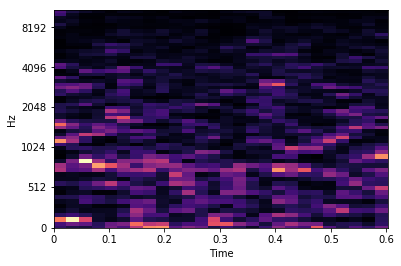

In [36]:
import librosa.display
spec = load_mel(os.path.join(os.getcwd(), 'test','rec8.wav'),start=0, stop=0.3, n_mels=60)
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

In [210]:
X_test = np.load(os.path.join(os.getcwd(), 'test', 'tmp_X_test.npy'))
X = np.load(os.path.join(os.getcwd(), 'train', 'tmp_X_train.npy'))
y = np.load(os.path.join(os.getcwd(), 'train', 'tmp_y_train.npy'))

In [211]:
y.sum()

3314

# Model i Trenowanie

In [16]:
X.shape

(3799, 60, 26)

In [236]:

X_test = np.load(os.path.join(os.getcwd(), 'test', 'tmp_X_test.npy'))
X = np.load(os.path.join(os.getcwd(), 'train', 'tmp_X_train.npy'))
y = np.load(os.path.join(os.getcwd(), 'train', 'tmp_y_train.npy'))

import torch
from torch import nn
torch.manual_seed(43)
class ConvNet(torch.nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=(1,20), padding=1)
        self.conv2 = torch.nn.Conv2d(8, 8, kernel_size=(20,1), padding=1)
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(8)
        self.batch_norm2 = torch.nn.BatchNorm2d(8)
        
        self.pool2 = torch.nn.MaxPool2d((2,60))
        
        self.dense = torch.nn.Linear(176, 2)
    
    def forward(self, x):
        log = False 
        if log:
            print(x.shape)
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.relu2(self.batch_norm2(self.conv2(out)))
        if log:
            print(out.shape)
        out = self.pool2(out)
        if log:
            print(out.shape)
        out = out.view(out.size(0), -1)
        
        if log:
            print(out.shape)
        return self.dense(out)
    
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=6)
        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.7, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

clf = ConvNet()
# clf = AlexNet()
# clf = CNN()

# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.90)

X_train = torch.Tensor(X[:split_point]).unsqueeze(1)#.expand(-1, 3, 60, 26)
print(X_train.shape)
# X_train = torch.nn.functional.interpolate(X_train, size=(224, 224))
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:]).unsqueeze(1)#.expand(-1, 3, 60, 26)
# X_valid = torch.nn.functional.interpolate(X_valid, size=(224, 224))
y_valid = torch.LongTensor(y[split_point:])
batch_size = 256 
# 224 by 224
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

# Ustawienie kosztu i optimizera
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters())

# Pętla uczenia
best_preds, best_score = None, 0.
losses, scores = [], []
epochs_number = 30 
for epoch in trange(epochs_number):
    running_loss = 0
    clf.train()
    i = 0
    for X, y in data_loader:
        print(i)
        optimizer.zero_grad()

        outputs = clf(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        i += 1
        
    losses.append(running_loss)
    
    clf.eval()
    preds = []
    for X, _ in valid_data_loader:
        out = clf(X)
        preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    preds = np.concatenate(preds, axis = 0)
    
    # Metryką testującą jest ROC AUC
    score = roc_auc_score(y_valid.numpy(), preds)
    scores.append(score)
    print(score)
    if score > best_score:
        best_score = score
        best_preds = preds
        np.save('tmp_preds', best_preds)
        # Model dający najlepszy wynik powinien być zapisany
        torch.save(clf.state_dict(), 'tmp_model.pt')














  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([62705, 1, 60, 26])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















  3%|▎         | 1/30 [00:48<23:39, 48.95s/it]

0.530052575557
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















  7%|▋         | 2/30 [01:37<22:44, 48.72s/it]

0.58528629344
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 10%|█         | 3/30 [02:25<21:52, 48.60s/it]

0.587917761301
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 13%|█▎        | 4/30 [03:14<21:09, 48.83s/it]

0.804395463868
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 17%|█▋        | 5/30 [04:01<20:02, 48.10s/it]

0.495280036022
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 20%|██        | 6/30 [04:49<19:12, 48.01s/it]

0.810913607898
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 23%|██▎       | 7/30 [05:35<18:10, 47.42s/it]

0.60946260696
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 27%|██▋       | 8/30 [06:20<17:09, 46.78s/it]

0.57175131563
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 30%|███       | 9/30 [07:11<16:52, 48.22s/it]

0.80878931372
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 33%|███▎      | 10/30 [07:59<15:57, 47.89s/it]

0.810737307622
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 37%|███▋      | 11/30 [08:52<15:43, 49.66s/it]

0.816372501792
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 40%|████      | 12/30 [09:38<14:33, 48.50s/it]

0.467174212815
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 43%|████▎     | 13/30 [10:33<14:18, 50.48s/it]

0.829343401486
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 47%|████▋     | 14/30 [11:26<13:37, 51.10s/it]

0.549858007923
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 50%|█████     | 15/30 [12:13<12:28, 49.92s/it]

0.543429048657
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 53%|█████▎    | 16/30 [13:04<11:42, 50.16s/it]

0.564562527004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 57%|█████▋    | 17/30 [14:00<11:16, 52.04s/it]

0.709308157985
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 60%|██████    | 18/30 [14:49<10:12, 51.01s/it]

0.778093821544
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 63%|██████▎   | 19/30 [15:46<09:41, 52.88s/it]

0.80512073672
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 67%|██████▋   | 20/30 [16:40<08:53, 53.35s/it]

0.444335049985
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 70%|███████   | 21/30 [17:29<07:46, 51.83s/it]

0.495386188653
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 73%|███████▎  | 22/30 [18:21<06:55, 51.94s/it]

0.589482943569
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 77%|███████▋  | 23/30 [19:12<06:00, 51.55s/it]

0.600106690637
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 80%|████████  | 24/30 [20:01<05:05, 50.90s/it]

0.619470337685
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 83%|████████▎ | 25/30 [20:51<04:13, 50.63s/it]

0.694900162726
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 87%|████████▋ | 26/30 [21:37<03:17, 49.30s/it]

0.784168938705
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 90%|█████████ | 27/30 [22:22<02:24, 48.03s/it]

0.878099946531
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 93%|█████████▎| 28/30 [23:12<01:37, 48.56s/it]

0.721272987321
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















 97%|█████████▋| 29/30 [24:08<00:50, 50.87s/it]

0.725214705595
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244















100%|██████████| 30/30 [25:05<00:00, 52.63s/it]

0.754394263702


In [237]:
X_train.expand(-1,3, 60, 26).shape


torch.Size([62705, 3, 60, 26])

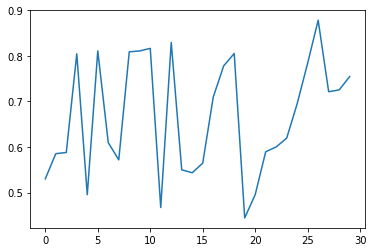

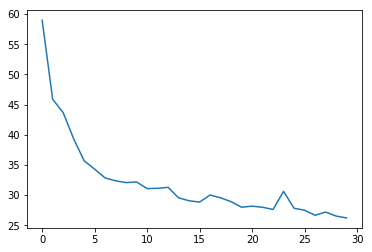

In [238]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Zapis Predykcji

In [239]:
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('submission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')
        
def save_predictions_2(preds: dict):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for line in lines:
        print(line.split(',')[0])
        indx = line.split(',')[0]
        output_lines.append("{},{}".format(indx, preds[indx]))
    
    with open('submission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [240]:
X_test.shape

(13198, 60, 26)

In [243]:
# Wczytanie najlepszego modelu
from collections import defaultdict
clf.load_state_dict(torch.load('tmp_model.pt'))

# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test).unsqueeze(1)#.expand(-1, 3, 60, 26)
# X_test_tensor = torch.nn.functional.interpolate(X_test_tensor, size=(224, 224))
print(X_test_tensor.shape)
test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

# Ewaluacja modelu na danych testowych
clf.eval()
preds = []
for i, X in enumerate(test_data_loader):
    if i == 0:
        print(type(X[0][0]))
        assert torch.all(torch.eq(X[0][0], torch.tensor(assert_x, dtype=torch.float)))
        print(recordings_ids[0])
    
    out = clf(X[0])
    print('out :',out)
    
    preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    print(preds)
    
preds = np.concatenate(preds, axis = 0)

torch.Size([13198, 1, 60, 26])
<class 'torch.Tensor'>
1/1
out : tensor([[-6.7376e-01,  1.1085e+00],
        [ 2.4914e-01,  2.7846e-01],
        [-8.9137e-01,  1.2885e+00],
        [-5.8291e-01,  9.8588e-01],
        [-2.8474e+00,  3.2078e+00],
        [-2.4237e+00,  2.7887e+00],
        [-2.4984e+00,  2.6463e+00],
        [-2.3372e+00,  2.4715e+00],
        [-2.0961e+00,  2.1859e+00],
        [-1.8316e+00,  1.8915e+00],
        [-3.0051e+00,  2.8630e+00],
        [-3.0725e+00,  3.1392e+00],
        [-1.9292e+00,  1.9212e+00],
        [-2.1845e+00,  2.1681e+00],
        [-1.3077e+00,  1.1894e+00],
        [ 1.1259e+00, -1.4738e+00],
        [ 4.4715e-02, -2.8813e-01],
        [ 2.6723e-01, -5.0663e-01],
        [-3.1032e-02, -3.0115e-01],
        [-2.6850e-01,  1.2812e-03],
        [-2.6545e-02, -2.6268e-01],
        [-2.8722e-01,  3.2810e-02],
        [ 2.2621e-01, -5.1544e-01],
        [ 6.8333e-01, -7.3851e-01],
        [ 9.4103e-01, -1.2890e+00],
        [ 1.2062e+00, -1.5206e+00],


[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

out : tensor([[-1.0812,  1.0697],
        [-1.1445,  1.0865],
        [-2.5483,  2.6016],
        [-1.4629,  1.5408],
        [-0.8814,  0.9706],
        [-0.2854,  0.2633],
        [-0.4537,  0.6044],
        [-0.1547,  0.2663],
        [ 1.6412, -2.1001],
        [ 0.2621, -0.7010],
        [ 0.6838, -1.1934],
        [ 0.3590, -0.7945],
        [ 0.5078, -1.1325],
        [ 2.1910, -2.7457],
        [ 2.0999, -2.6652],
        [ 2.3343, -2.8801],
        [ 1.6728, -2.1917],
        [ 1.6949, -2.2189],
        [ 1.0087, -1.3596],
        [ 0.7288, -1.1137],
        [ 2.1401, -2.4001],
        [ 2.5256, -2.8133],
        [ 1.5326, -2.1383],
        [ 1.4938, -2.1062],
        [ 1.6547, -2.2279],
        [ 1.9737, -2.6884],
        [ 1.9255, -2.6208],
        [ 1.6455, -2.2143],
        [ 1.1253, -1.6212],
        [ 2.3588, -3.0170],
        [ 2.1801, -2.8809],
        [ 2.2224, -2.8239],
        [ 1.8304, -2.3025],
        [ 2.4523, -2.9935],
        [ 1.8213, -2.3631],
        [ 1.86

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

out : tensor([[ 1.1745e+00, -7.2850e-01],
        [ 1.9026e+00, -1.8283e+00],
        [ 1.6600e+00, -1.4807e+00],
        [ 1.0946e+00, -1.2368e+00],
        [ 2.4902e+00, -2.6061e+00],
        [ 3.0077e+00, -3.5457e+00],
        [-3.5685e-02, -1.8134e-01],
        [-3.2774e-02,  9.8460e-02],
        [-7.1442e-01,  9.4542e-01],
        [-2.2464e+00,  2.4270e+00],
        [ 5.9175e-01, -5.8712e-01],
        [ 1.5828e+00, -1.5833e+00],
        [ 2.0846e+00, -2.0737e+00],
        [ 2.4931e+00, -2.4747e+00],
        [ 3.2709e+00, -3.2273e+00],
        [ 3.3697e+00, -3.2875e+00],
        [ 3.9282e+00, -3.9234e+00],
        [ 3.4079e+00, -3.1064e+00],
        [ 3.4919e+00, -3.1699e+00],
        [ 2.2787e+00, -2.0620e+00],
        [ 3.9484e+00, -4.0629e+00],
        [ 3.3540e+00, -3.3176e+00],
        [ 3.6590e+00, -3.4843e+00],
        [ 2.5007e+00, -2.6397e+00],
        [ 3.1976e+00, -3.2903e+00],
        [ 4.3134e+00, -4.6909e+00],
        [ 3.7315e+00, -3.9238e+00],
        [ 4.2657e+00, 

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

out : tensor([[  1.5537,  -1.2572],
        [  1.6004,  -1.2953],
        [  1.5674,  -1.2716],
        [  1.5767,  -1.2818],
        [  1.6137,  -1.3214],
        [  1.6078,  -1.3141],
        [  1.5478,  -1.2538],
        [  1.5908,  -1.2888],
        [  1.5922,  -1.2851],
        [  1.6133,  -1.3050],
        [  1.6120,  -1.3290],
        [  1.6140,  -1.3207],
        [  1.6896,  -1.3821],
        [  1.6656,  -1.3657],
        [  1.6938,  -1.3840],
        [  1.7353,  -1.4244],
        [  1.6518,  -1.3391],
        [  1.6807,  -1.3654],
        [  1.6483,  -1.3499],
        [  1.6659,  -1.3605],
        [  1.6326,  -1.3320],
        [  1.6234,  -1.3209],
        [  1.6194,  -1.3207],
        [  1.5965,  -1.3046],
        [  1.6279,  -1.3281],
        [  1.6144,  -1.3032],
        [  1.5757,  -1.2610],
        [  1.5145,  -1.2067],
        [  1.4025,  -1.0852],
        [  0.7364,  -0.3589],
        [  0.7910,  -0.4294],
        [  1.2536,  -0.9157],
        [  0.6779,  -0.3148],
    

out : tensor([[ 0.8729, -0.6198],
        [ 1.6971, -1.3845],
        [ 1.7168, -1.3931],
        [ 1.6507, -1.3243],
        [ 1.6179, -1.3022],
        [ 1.5626, -1.2201],
        [ 1.5773, -1.2296],
        [ 1.5448, -1.1950],
        [ 1.6126, -1.2751],
        [ 1.7495, -1.4067],
        [ 1.7160, -1.3697],
        [ 1.7986, -1.4696],
        [ 1.7774, -1.4740],
        [ 1.6858, -1.3798],
        [ 1.7254, -1.4259],
        [ 1.5870, -1.3020],
        [ 1.6173, -1.3149],
        [ 1.6317, -1.3074],
        [ 1.6424, -1.3278],
        [ 1.6475, -1.3412],
        [ 1.6489, -1.3314],
        [ 1.6078, -1.2988],
        [ 1.5593, -1.2569],
        [ 0.9239, -0.6535],
        [ 0.4207, -0.1447],
        [-0.6757,  1.0108],
        [-0.9025,  1.3415],
        [-1.4635,  1.8515],
        [-1.4193,  1.8096],
        [ 1.7164, -1.4157],
        [ 1.7236, -1.4213],
        [ 1.6696, -1.3689],
        [ 1.6561, -1.3514],
        [ 1.6010, -1.2886],
        [ 1.5811, -1.2657],
        [ 1.56

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

[array([ 0.85597086,  0.50732899,  0.8984226 ,  0.8276118 ,  0.99765968,
        0.99458069,  0.99420315,  0.9919076 ,  0.98637402,  0.97641128,
        0.99717987,  0.99799818,  0.97917181,  0.98729056,  0.9239378 ,
        0.06915832,  0.41754818,  0.31564543,  0.4328787 ,  0.56703883,
        0.44123948,  0.57933235,  0.32264206,  0.19437219,  0.09708819,
        0.06141009,  0.45712548,  0.89264745,  0.91231441,  0.97357833,
        0.95578372,  0.99056363,  0.98549694,  0.98526472,  0.97085214,
        0.981848  ,  0.865107  ,  0.60111904,  0.67167562,  0.71669048,
        0.95222098,  0.43674645,  0.80424333,  0.91442245,  0.16419752,
        0.0180144 ,  0.19904026,  0.05467102,  0.0675253 ,  0.08612768,
        0.17645364,  0.12480502,  0.06996359,  0.5958879 ,  0.31699568,
        0.91846973,  0.92757201,  0.95960325,  0.99662977,  0.99173319,
        0.93657601,  0.97077429,  0.97923261,  0.63576221,  0.7925449 ,
        0.8432343 ,  0.70357704,  0.91662347,  0.90710306,  0.7

In [244]:
preds.shape

(13198,)

In [245]:
global_mean = preds.mean()

In [246]:
max_value = preds.max()

In [247]:
global_std = preds.std()

In [248]:
global_mean

0.2150563

In [249]:
prediction_dict = defaultdict(list) 
for i, pred in enumerate(preds):
    prediction_dict[str(recordings_ids[i])].append(pred)

In [228]:
# averaging
final_preds_dict= defaultdict(float) 

for k in prediction_dict.keys():
    v = prediction_dict[k] - global_mean
    final_preds_dict[k] = (np.maximum(v, 0, v  ) / (max_value - global_mean)).max()

In [251]:
# only max value
final_preds_dict= defaultdict(float) 

for k in prediction_dict.keys():
    final_preds_dict[k] = np.array(prediction_dict[k]).max() 

In [250]:
prediction_dict

defaultdict(list,
            {'1/1': [0.85597086,
              0.50732899,
              0.8984226,
              0.8276118,
              0.99765968,
              0.99458069,
              0.99420315,
              0.9919076,
              0.98637402,
              0.97641128,
              0.99717987,
              0.99799818,
              0.97917181,
              0.98729056,
              0.9239378],
             '1/2': [0.069158316,
              0.41754818,
              0.31564543,
              0.4328787,
              0.56703883,
              0.44123948,
              0.57933235,
              0.32264206,
              0.19437219,
              0.097088188,
              0.061410092,
              0.45712548,
              0.89264745,
              0.91231441,
              0.97357833],
             '1/6': [0.95578372,
              0.99056363,
              0.98549694,
              0.98526472,
              0.97085214,
              0.981848,
              0.865107,
   

In [252]:
final_preds_dict

defaultdict(float,
            {'1/1': 0.99799818,
             '1/2': 0.97357833,
             '1/6': 0.99056363,
             '1/7': 0.95960325,
             '1/8': 0.99662977,
             '2/2': 0.99512464,
             '2/3': 0.96059948,
             '2/4': 0.97289127,
             '2/5': 0.99782503,
             '2/9': 0.9577018,
             '3/1': 0.96748382,
             '3/2': 0.99321657,
             '3/6': 0.99918121,
             '3/7': 0.99703336,
             '3/8': 0.99544781,
             '4/3': 0.99979991,
             '4/4': 0.80931914,
             '4/5': 0.89925313,
             '4/6': 0.99997818,
             '4/8': 0.2556209,
             '5/1': 0.2282034,
             '5/3': 0.23374152,
             '5/6': 0.5270412,
             '5/8': 0.45907784,
             '5/9': 0.25573799,
             '6/1': 0.92421418,
             '6/4': 0.9985677,
             '6/5': 0.30781165,
             '6/7': 0.77396649,
             '6/8': 0.90508807,
             '7/0': 0.8088

In [180]:
y.shape

torch.Size([255])

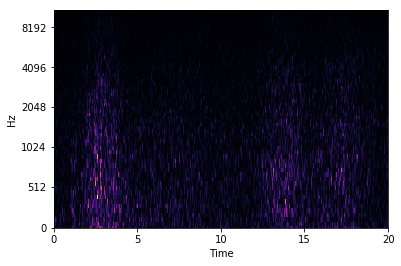

In [267]:
import librosa.display
spec = load_mel(os.path.join(os.getcwd(), 'test','rec25.wav'),start=0, stop=10, n_mels=60)
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

In [268]:
save_predictions_2(final_preds_dict)

1/1
1/2
1/6
1/7
1/8
2/2
2/3
2/4
2/5
2/9
3/1
3/2
3/6
3/7
3/8
4/3
4/4
4/5
4/6
4/8
5/1
5/3
5/6
5/8
5/9
6/1
6/4
6/5
6/7
6/8
7/0
7/1
7/3
7/7
7/9
8/3
8/4
8/5
8/6
8/9
9/2
9/3
9/6
9/8
9/9
10/1
10/2
10/6
10/7
10/9
11/1
11/4
11/5
11/7
11/8
12/1
12/3
12/4
12/7
12/9
13/3
13/5
13/7
13/8
13/9
14/2
14/4
14/5
14/6
14/8
15/1
15/5
15/6
15/7
15/8
16/1
16/2
16/3
16/8
16/9
17/4
17/5
17/6
17/7
17/8
18/0
18/1
18/3
18/6
18/9
19/0
19/1
19/2
19/3
19/4
19/6
19/7
19/8
19/9
20/0
20/2
20/5
20/6
20/8
21/1
21/3
21/5
21/6
21/8
22/1
22/2
22/4
22/8
22/9
23/0
23/1
23/5
23/6
23/8
24/0
24/4
24/5
24/7
24/9
25/0
25/1
25/3
25/6
25/9
26/0
26/1
26/7
26/8
26/9
27/0
27/2
27/6
27/7
27/9
28/0
28/3
28/4
28/7
28/9
29/0
29/1
29/2
29/5
29/9
30/1
30/2
30/3
30/4
30/8
31/0
31/1
31/2
31/3
31/4
31/5
31/6
31/8
31/9
32/0
32/5
32/6
32/8
32/9
33/2
33/5
33/6
33/8
33/9
34/0
34/2
34/3
34/4
34/5
35/4
35/5
35/7
35/8
35/9
36/2
36/3
36/4
36/5
36/9
37/1
37/2
37/5
37/7
37/8
38/1
38/4
38/5
38/6
38/7
39/0
39/2
39/4
39/6
39/9
40/0
40/1
40/3
40/6
40/7
41/1
